**Initialization**

In [1]:
import numpy as np

import datetime as dt

%tensorflow_version 2.x
import tensorflow as tf

import matplotlib.pyplot as plt

# **Task 1: Data set**

The Cifar10 dataset comes directly in a two-part dataset for training and test data. The training dataset contains 50000 image-label pairs and the test dataset 10000 image-label pairs. The labels are displayed as numbers from 0 to 9. Among other things in the following code snippet these numbers are mapped to their string label class names. The images in the datasets come up with a fixed shape of 32 x 32 x 3. Thus no resizing is necessary. 

Additionally, some example images of the dataset are displayed with the corresponding string label class name.

170500096/170498071 [==============================] - 2s 0us/step
Training inputs shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test inputs shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


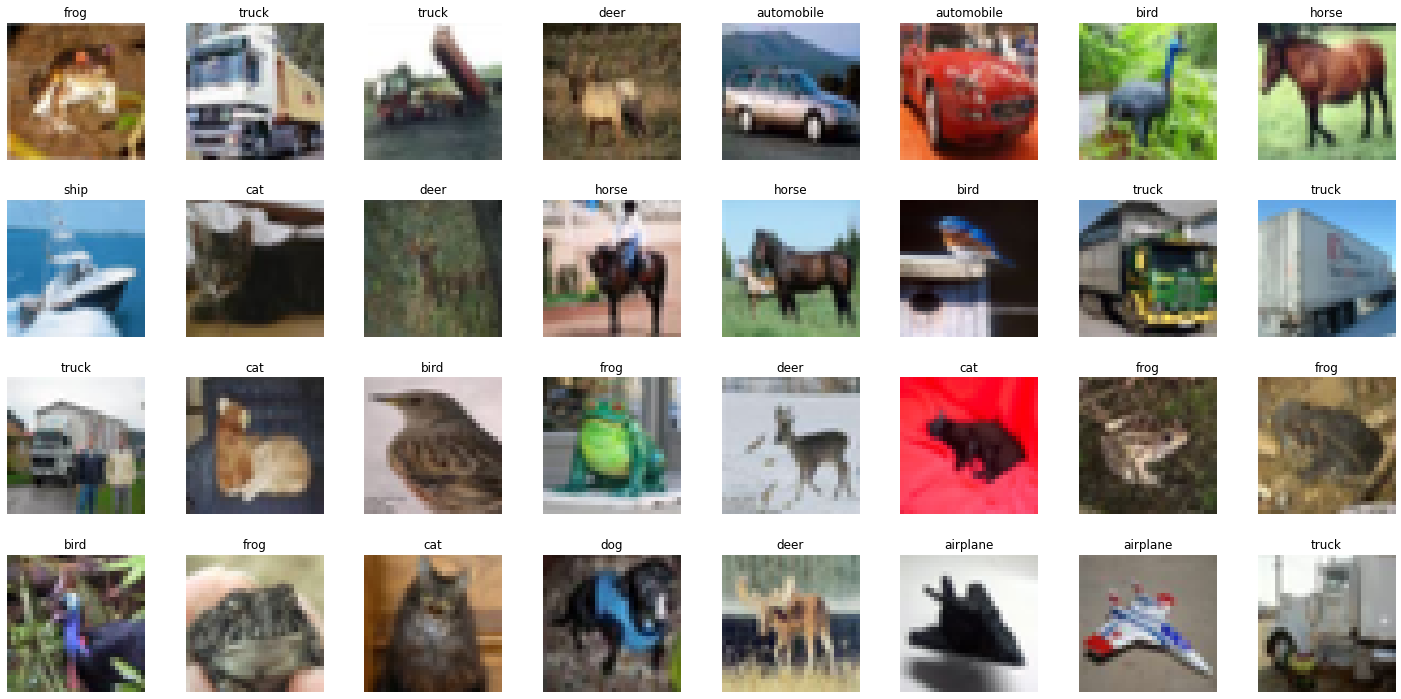

In [2]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.cifar10.load_data()

print("Training inputs shape: " + str(training_inputs.shape))
print("Training labels shape: " + str(training_labels.shape))
print("Test inputs shape: " + str(test_inputs.shape))
print("Test labels shape: " + str(test_labels.shape))

label_encoding = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(4, 8, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(32):
  image = training_inputs[i]
  label = label_encoding[training_labels[i][-1]]

  ax[i].imshow(image)
  ax[i].set_title(label)
  ax[i].axis("off")

Input pipeline

In [3]:
batch_size = 128

# Creates tensorflow datasets for the training and test data.
training_dataset = tf.data.Dataset.from_tensor_slices((training_inputs, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

# Conducts the normalization of the inputs (images) and the one-hot-encoding of the targets.
training_dataset = training_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))  # tf.squeeze(tar) to remove dimensions of size 1 from the shape of the target-tensors.
test_dataset = test_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))     
                                                                                          
# Batches, shuffles and prefetches the training- and test datasets.
training_dataset = training_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)
test_dataset = test_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)

# **Task 2.2: Model - DenseNet**

**Class TransitionLayer**

Implementation of a callable Transition Layer for the DenseNet. 

This one should include:

*   Concolutional Layer
*   Batch Normalization
*   Activation Function ReLu
*   Pooling Layer (AveragePooling)













In [4]:
# Description: The class TransitionLayer describes a transition layer of a DenseNet.
class TransitionLayer(tf.keras.layers.Layer): 
  
  def __init__(self, num_channels_trans_layer):
    super(TransitionLayer, self).__init__()

    self.conv_1 = tf.keras.layers.Conv2D(filters = num_channels_trans_layer,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         
    self.activ_1 = tf.keras.activations.relu                         
    self.aver_pool_1 = tf.keras.layers.AveragePooling2D(strides=(2, 2), padding = 'same')   #Without strides?

  # Description: This function conducts one forward-step of the transition layer. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.aver_pool_1(x)
    return x

**Class ConvolutionalBlock**

This class is needed to create a Dense Block. It includes a bottleneck layer and a convolutional layer. When calling, the forward step is conducted and the output of the convolutional layer is concatenate with the input of the bottleneck layer. The result of the concatenation is the output of the convolutional block.

The bottleneck layer is needed to get a lower number of parameters and so a faster network.

In [5]:
# Description: The class ConvolutionalBlock describes a convolutional block of a DenseBlock.
class ConvolutionalBlock(tf.keras.layers.Layer): 
  
  def __init__(self, num_filter):
    super(ConvolutionalBlock, self).__init__()

    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_1 = tf.keras.activations.relu                
    self.conv_1 = tf.keras.layers.Conv2D(filters = num_filter,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.conv_2 = tf.keras.layers.Conv2D(filters = num_filter,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_2 = tf.keras.activations.relu          
    self.concat = tf.keras.layers.Concatenate()               

  # Description: This function conducts one forward-step of the convolutional block. Therefore the block output
  #              is concatenated with the block input. The python decorator @tf.function is used to bundle multiple 
  #              computations into one computational graph.
  #              @parameters: block_input, training (to differ between training and test calls of the residual block)
  #              @returns: block_output
  @tf.function
  def call(self, block_input, training = True):
    x = self.batch_norm_1(block_input, training)
    x = self.activ_1(x)
    x = self.conv_1(x)
    x = self.conv_2(x) 
    x = self.batch_norm_2(x, training)
    x = self.activ_2(x)

    block_output = self.concat([x, block_input]) 
    return block_output

**Class DenseBlock**

Implementation of the Dense Blocks for the DenseNet. They include as many convolutional blocks as the init parameter list_num_filter defines. The total number of convolutional layers of the Dense Block is list_num_filter.

In [6]:
# Description: The class DenseBlock describes a dense block of a DenseNet.
class DenseBlock(tf.keras.layers.Layer): 

  def __init__(self, list_num_filter):
    super(DenseBlock, self).__init__()

    self.convolutional_blocks = []
    for num_filter in list_num_filter:
      self.convolutional_blocks.append(ConvolutionalBlock(num_filter))

  # Description: This function conducts one forward-step of the dense block. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (output) x
  @tf.function
  def call(self, x, training = True):
    for conv_block in self.convolutional_blocks:
      x = conv_block(x, training)
    return x

**Class DenseNet**

In [7]:
# The class DenseNet describes a dense convolutional neural network with a feature extractor and a classifier.
class DenseNet(tf.keras.Model): 
  
  def __init__(self, num_dense_blocks, list_num_filter, growth_rate):
    super(DenseNet, self).__init__()
    num_conv_blocks = len(list_num_filter)
    # Feature extractor
    self.conv_1 = tf.keras.layers.Conv2D(filters = 32,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (32, 32, 3))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_1 = tf.keras.activations.relu
    self.dropout_1 = tf.keras.layers.Dropout(rate = 0.5)    

    num_channels_trans_layer = growth_rate * num_conv_blocks
    self.dense_blocks_and_trans_layers = []
    for _ in range(num_dense_blocks - 1):                         # The last dense block does not need a transition layer -> num_dense_blocks - 1 
      self.dense_blocks_and_trans_layers.append(DenseBlock(list_num_filter))   
      self.dense_blocks_and_trans_layers.append(TransitionLayer(num_channels_trans_layer)) 
    self.last_dense_block = DenseBlock(list_num_filter)

    # Classifier
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dropout_2 = tf.keras.layers.Dropout(rate = 0.5)                                               # (5)    
    self.output_layer = tf.keras.layers.Dense(10, 
                                              activation=tf.keras.activations.softmax)#,
                                              #kernel_initializer = tf.keras.initializers.glorot_normal,   
                                              #bias_initializer = 'zeros',                                 
                                              #kernel_regularizer = tf.keras.regularizers.L2(0.01))

  # Description: This function conducts one forward-step of the Dense CNN. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.dropout_1(x, training)

    for i in self.dense_blocks_and_trans_layers:
      x = i(x, training)
    x = self.last_dense_block(x, training)

    x = self.global_pool(x)
    x = self.dropout_2(x, training)
    x = self.output_layer(x)
    return x

# **Task 3: Training and Analysis**

In [8]:
# Description: This function conducts a forward-step and the backpropagation of a CNN. It does not matter whether the CNN is a ResNet or 
#              a DenseNet (this is defined by the parameter model). Additionally, the average training loss and accuracy is determined.
#              @parameters: model, training_data, loss_fn, optimizer, training (to differ between training and test calls of the CNN)
#              @returns: training_loss, training_accuracy
#@tf.function
def training_step(model, training_data, loss_fn, optimizer, training = True):
  training_losses = []
  training_accuracies = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction = model(input, training)
      current_training_loss = loss_fn(target, prediction)+ tf.math.reduce_sum(model.losses)   # (3)
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())

    current_training_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    training_accuracies.append(np.mean(current_training_accuracy))  
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy


# Description: This function determines the average test loss and accuracy of a CNN. It does not matter 
#              whether the CNN is a ResNet or a DenseNet (this is defined by the parameter model).
#              @parameters: model, test_data, loss_fn, training (to differ between training and test calls of the CNN)
#              @returns: test_loss, test_accuracy
#@tf.function
def test(model, test_data, loss_fn, training = False):
  test_losses = []
  test_accuracies = []

  for (input, target) in test_data:
    prediction = model(input, training)
    
    current_test_loss = loss_fn(target, prediction)
    test_losses.append(current_test_loss.numpy())

    current_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_accuracies.append(np.mean(current_test_accuracy))   
    
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)
  return test_loss, test_accuracy

Epoch 0
2020-12-09 11:34:27.972057
Training accuracy: 0.27140744884910484
Test accuracy: 0.1507120253164557
Epoch 1
2020-12-09 11:35:53.732007
Training accuracy: 0.40084718670076724
Test accuracy: 0.30844541139240506
Epoch 2
2020-12-09 11:37:03.745922
Training accuracy: 0.4856817455242967
Test accuracy: 0.3642207278481013
Epoch 3
2020-12-09 11:38:13.978471
Training accuracy: 0.5403492647058824
Test accuracy: 0.40812895569620256
Epoch 4
2020-12-09 11:39:24.076790
Training accuracy: 0.5791240409207161
Test accuracy: 0.442246835443038
Epoch 5
2020-12-09 11:40:34.298209
Training accuracy: 0.6107816496163683
Test accuracy: 0.5011867088607594
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
______

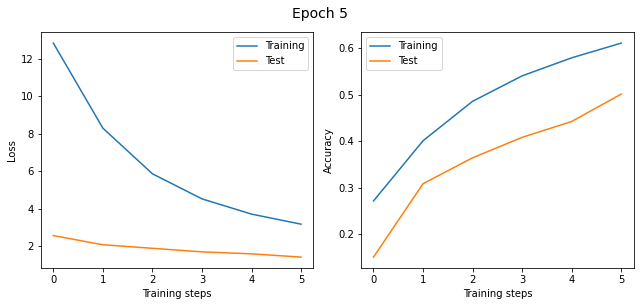

Epoch 6
2020-12-09 11:41:44.867101
Training accuracy: 0.637056425831202
Test accuracy: 0.5211629746835443
Epoch 7
2020-12-09 11:42:55.320473
Training accuracy: 0.6632233056265985
Test accuracy: 0.5604232594936709
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  42448     
_________________________________________________________________
transition_layer (Transition multiple                  31400     
__________________________________________

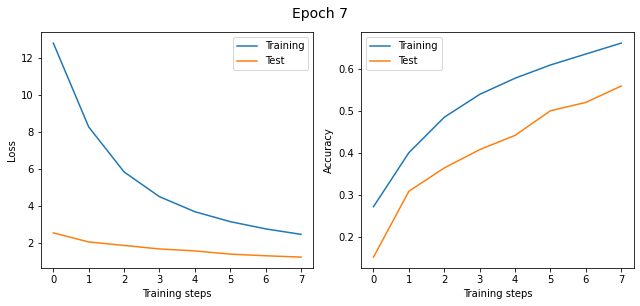

Epoch 8
2020-12-09 11:44:04.922642
Training accuracy: 0.6817575127877238
Test accuracy: 0.5994857594936709
Epoch 9
2020-12-09 11:45:14.268583
Training accuracy: 0.7044597186700768
Test accuracy: 0.4747824367088608
Epoch 10
2020-12-09 11:46:23.669357
Training accuracy: 0.7228500639386188
Test accuracy: 0.6991693037974683
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  42448     
_________________________________________________________________

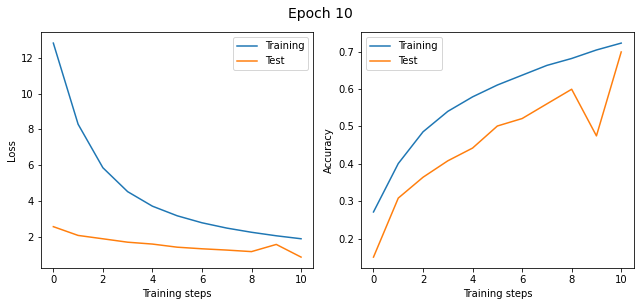

Epoch 11
2020-12-09 11:47:33.396751
Training accuracy: 0.7390744884910485
Test accuracy: 0.6921479430379747
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  42448     
_________________________________________________________________
transition_layer (Transition multiple                  31400     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  65968     
_______________

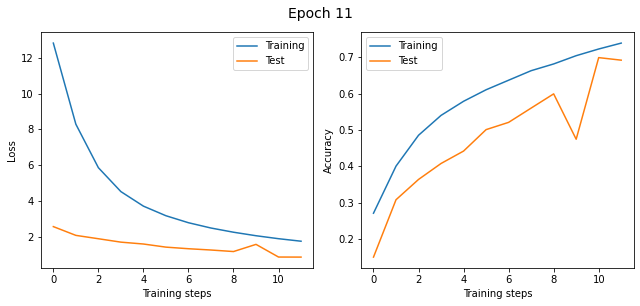

Epoch 12
2020-12-09 11:48:42.840166
Training accuracy: 0.7507113171355498
Test accuracy: 0.6526898734177216
Epoch 13
2020-12-09 11:49:52.033383
Training accuracy: 0.7661804667519182
Test accuracy: 0.6574367088607594
Epoch 14
2020-12-09 11:51:01.059351
Training accuracy: 0.7752797314578005
Test accuracy: 0.6903678797468354
Epoch 15
2020-12-09 11:52:10.681593
Training accuracy: 0.7864010549872124
Test accuracy: 0.689873417721519
Epoch 16
2020-12-09 11:53:20.649181
Training accuracy: 0.794373401534527
Test accuracy: 0.6979825949367089
Epoch 17
2020-12-09 11:54:30.168768
Training accuracy: 0.8036325127877237
Test accuracy: 0.7763053797468354
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_____

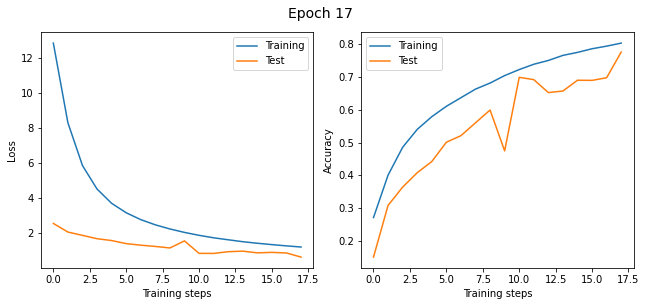

Epoch 18
2020-12-09 11:55:40.306678
Training accuracy: 0.8105658567774936
Test accuracy: 0.7098496835443038
Epoch 19
2020-12-09 11:56:49.904015
Training accuracy: 0.818162563938619
Test accuracy: 0.6865110759493671
Epoch 20
2020-12-09 11:57:59.600037
Training accuracy: 0.8223825127877238
Test accuracy: 0.6376582278481012
Epoch 21
2020-12-09 11:59:08.686140
Training accuracy: 0.8286365089514066
Test accuracy: 0.7277492088607594
Epoch 22
2020-12-09 12:00:17.623868
Training accuracy: 0.8342111572890025
Test accuracy: 0.7854034810126582
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dropout (Dropout)            multiple         

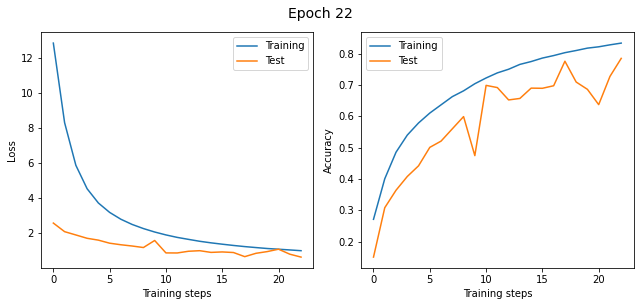

Epoch 23
2020-12-09 12:01:27.038917
Training accuracy: 0.8381553708439897
Test accuracy: 0.7215189873417721
Epoch 24
2020-12-09 12:02:35.962062
Training accuracy: 0.8448489450127877
Test accuracy: 0.7960838607594937
Epoch 25
2020-12-09 12:03:45.006607
Training accuracy: 0.8483296035805626
Test accuracy: 0.7300237341772152
Epoch 26
2020-12-09 12:04:54.329358
Training accuracy: 0.8500599424552431
Test accuracy: 0.7365506329113924
Epoch 27
2020-12-09 12:06:03.757729
Training accuracy: 0.8541919757033247
Test accuracy: 0.7745253164556962
Epoch 28
2020-12-09 12:07:13.257694
Training accuracy: 0.8575367647058824
Test accuracy: 0.7721518987341772
Epoch 29
2020-12-09 12:08:23.097143
Training accuracy: 0.8616528132992327
Test accuracy: 0.7800632911392406
Epoch 30
2020-12-09 12:09:32.476437
Training accuracy: 0.8657728580562659
Test accuracy: 0.7848101265822784
Epoch 31
2020-12-09 12:10:42.126297
Training accuracy: 0.8670756074168798
Test accuracy: 0.7892602848101266
Epoch 32
2020-12-09 12:11:51

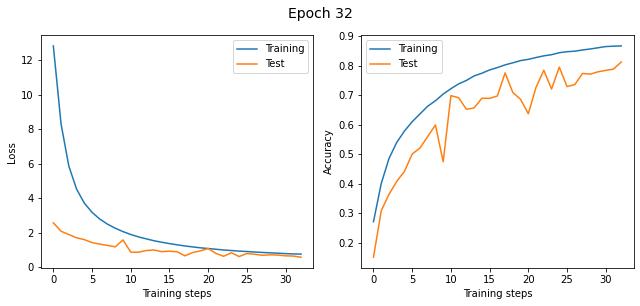

Epoch 33
2020-12-09 12:13:01.597802
Training accuracy: 0.8735094309462916
Test accuracy: 0.790743670886076
Epoch 34
2020-12-09 12:14:11.423017
Training accuracy: 0.8778013107416879
Test accuracy: 0.8012262658227848
Epoch 35
2020-12-09 12:15:20.798142
Training accuracy: 0.8760669757033248
Test accuracy: 0.8136867088607594
Epoch 36
2020-12-09 12:16:30.249515
Training accuracy: 0.8784287084398976
Test accuracy: 0.823378164556962
Epoch 37
2020-12-09 12:17:39.835810
Training accuracy: 0.8839154411764706
Test accuracy: 0.7652294303797469
Epoch 38
2020-12-09 12:18:49.602688
Training accuracy: 0.8853660485933504
Test accuracy: 0.8106210443037974
Epoch 39
2020-12-09 12:19:58.946077
Training accuracy: 0.8879915281329923
Test accuracy: 0.7939082278481012
Epoch 40
2020-12-09 12:21:07.624987
Training accuracy: 0.8892343350383632
Test accuracy: 0.8073575949367089
Epoch 41
2020-12-09 12:22:16.357254
Training accuracy: 0.8918398337595909
Test accuracy: 0.8017207278481012
Epoch 42
2020-12-09 12:23:25.1

In [9]:
# Description: This part creates objects of a ResNet and DenseNet and executes the training and testing of these models in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, the data for the visualization of the training and test progress is collected.
#              In order to better monitor the training progress, the loss and accuracy graphs are provided in addtion to the numerical outputs when the test accuracy 
#              has significantly improved.
tf.keras.backend.clear_session()

num_dense_blocks = 3
list_num_filter =[32, 32, 32, 16, 8]
num_conv_blocks = len(list_num_filter)
growth_rate = 40
model = DenseNet(num_dense_blocks, list_num_filter, growth_rate)   

n_epochs = 90
learning_rate = 0.0001
loss_fn = tf.keras.losses.CategoricalCrossentropy()                    # CategoricalCrossentropy because of 10 labels to differ.
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)    # Optimizer Adam (Adaptive Moment Estimation) with AMSGrad activated.
 


training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

dynamic_threshold_train_visio = 0.5                                    # Test accuracy threshold from which the training progress is displayed.
# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))
    ts_now = dt.datetime.now()
    print(ts_now)

    training_loss, training_accuracy = training_step(model, training_dataset, loss_fn, optimizer, training = True)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_fn, training = False)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print("Training accuracy: " + str(training_accuracy))
    print("Test accuracy: " + str(test_accuracy))

    # Visualization during training to check how the CNN is doing. In 5% steps of the test accuracy starting up from 50% test accuracy.
    if test_accuracy >= dynamic_threshold_train_visio: 
      model.summary()  #!!!find a different place for this!!!

      fig, ax = plt.subplots(1,2, figsize=(9, 4))

      fig.suptitle(('Epoch ' + str(epoch)), fontsize=14, y=1.05)
      line1, = ax[0].plot(training_losses)
      line2, = ax[0].plot(test_losses)
      ax[0].set_xlabel("Training steps")
      ax[0].set_ylabel("Loss")
      ax[0].legend((line1, line2),("Training", "Test"))

      line1, = ax[1].plot(training_accuracies)
      line2, = ax[1].plot(test_accuracies)
      ax[1].set_xlabel("Training steps")
      ax[1].set_ylabel("Accuracy")
      ax[1].legend((line1, line2),("Training", "Test"))

      fig.tight_layout()
      plt.draw()
      plt.show()

      # Increases the test accuracy threshold by 5%.  
      dynamic_threshold_train_visio += 0.05

# **Visualization**

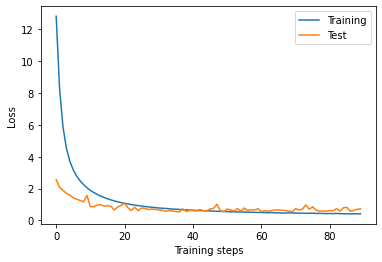

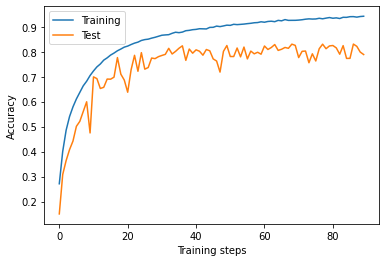

In [10]:
# Description: Figure 1 shows the loss for each epoch during the training and testing of the model.
#              Figure 2 shows the accuracy for each epoch during the training and testing of the model.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1, line2),("Training", "Test"))
plt.show()